# PyWren RISECamp, 2018

## Data Analytics with PyWren

In this section, we will use PyWren explore a dataset of Wikipedia statistics.

### The Dataset

We've prepared an S3 bucket with 20GB of Wikipedia traffic data obtained from http://aws.amazon.com/datasets/4182. To make the analysis more feasible for the short time you're here, we've shortened the dataset to three days worth of data (May 5 to May 7, 2009; roughly 20G and 329 million entries). 

Let's take a look into the bucket with our dataset. We'll print a few files from a few files from our bucket.

***Execute*** the code below to print out the names of the first 20 files.


In [3]:
# These lines are only needed for the solutions.
import sys
sys.path.append("..")

# some libraries that are useful for this tutorial
from training import wikipedia_bucket, list_keys_with_prefix, read_from_s3

filenames = list_keys_with_prefix(wikipedia_bucket, "wikistats_20090505_restricted-01/")
for filename in filenames[:20]:
    print(filename)

wikistats_20090505_restricted-01/part-00001
wikistats_20090505_restricted-01/part-00002
wikistats_20090505_restricted-01/part-00003
wikistats_20090505_restricted-01/part-00004
wikistats_20090505_restricted-01/part-00005
wikistats_20090505_restricted-01/part-00006
wikistats_20090505_restricted-01/part-00007
wikistats_20090505_restricted-01/part-00008
wikistats_20090505_restricted-01/part-00009
wikistats_20090505_restricted-01/part-00010
wikistats_20090505_restricted-01/part-00011
wikistats_20090505_restricted-01/part-00012
wikistats_20090505_restricted-01/part-00013
wikistats_20090505_restricted-01/part-00014
wikistats_20090505_restricted-01/part-00015
wikistats_20090505_restricted-01/part-00016
wikistats_20090505_restricted-01/part-00017
wikistats_20090505_restricted-01/part-00018
wikistats_20090505_restricted-01/part-00019
wikistats_20090505_restricted-01/part-00020


There are 74 files (2 of which are intentionally left empty). Each file consists of a list of records. Let's go take a look into the first file. This may take a while.

***Execute*** the code below to print out 20 records from the file.

In [4]:
# Read a file into memory, and split on newlines.
records = read_from_s3(wikipedia_bucket, "wikistats_20090505_restricted-01/part-00001").split("\n")

print("The total number of records in this file is {}, but here are the first 20".format(len(records)))
for i in range(20):
    print(records[i])

The total number of records in this file is 709288, but here are the first 20
20090505-000000 aa Main_Page 2 9980
20090505-000000 ab %D0%90%D0%B8%D0%BD%D1%82%D0%B5%D1%80%D0%BD%D0%B5%D1%82 1 465
20090505-000000 ab %D0%98%D1%85%D0%B0%D0%B4%D0%BE%D1%83_%D0%B0%D0%B4%D0%B0%D2%9F%D1%8C%D0%B0 1 16086
20090505-000000 af.b Tuisblad 1 36236
20090505-000000 af.d Tuisblad 4 189738
20090505-000000 af.q Tuisblad 2 56143
20090505-000000 af Afrika 1 46833
20090505-000000 af Afrikaans 2 53577
20090505-000000 af Australi%C3%AB 1 132432
20090505-000000 af Barack_Obama 1 23368
20090505-000000 af Duitsland 2 91024
20090505-000000 af Johannesburg 1 17488
20090505-000000 af Special:RecentChanges 1 1174
20090505-000000 af Spesiaal:Onlangse_wysigings 3 101681
20090505-000000 af Spesiaal:RecentChanges 2 2248
20090505-000000 af Suid-Afrika 1 30698
20090505-000000 af Tuisblad 14 155257
20090505-000000 af Varkgriep 4 42236
20090505-000000 af Wikipedia 2 32796
20090505-000000 af Wikipedia:Gebruikersportaal 2 24062


Each record some stats for a single Wikipedia page in a given time frame. The schema is:

`<date_time> <project_code> <page_name> <page_views> <page_size>`

- `<date_time>` specifies a date in YYYYMMDD-HHmmSS format (year, month, day, hour minute, second). This is the starting date-time of the record. mmSS is always 0000.
- `<project_code>` specifies the language the page is written in.
- `<page_title>` gives the page title.
- `<page_views>` gives the number of page views in the hour-long time slot starting at `<data_time>`. 
- `<page_size>` gives the size in bytes of the  page.

Now that we have a better understanding of the structure of our data, we can start running some interesting queries. 

Because the data are so large, it takes us quite a while to load just one file, as we saw in the previous exercise. You could imagine it would take way too long to process all of the data sequentially. We can use [PyWren](https://www.youtube.com/watch?v=VSaDPc1Cs5U) to help with this.

### To the ~~Batmobile~~ Cloud!!!!!!

***Execute*** the code below to initialize an executor.


In [5]:
# We need to load PyWren and create an executor instance
import pywren
pwex = pywren.default_executor()
print ("Done.")

Done.


## 1. Count
Let’s see how many records in total are in this data set.

***Exercise***: modify `count` to return the number of records in a given file.


In [6]:
def count(filename):
    data = read_from_s3(wikipedia_bucket, filename)
    return (len(data.split("\n")) if data else 0)    

print ("invoking pywren jobs...")
futures = pwex.map(count, filenames)
print ("working...")
pywren.wait(futures)

result = sum([f.result() for f in futures])
print(result)

invoking pywren jobs...
working...
51643989


This should launch 73 PyWren tasks. After finishing the job, let's plot again to check the execution. This should look more interesting than the simple job before.

***Execute*** the code below to show a plot of the executions.

Populating the interactive namespace from numpy and matplotlib


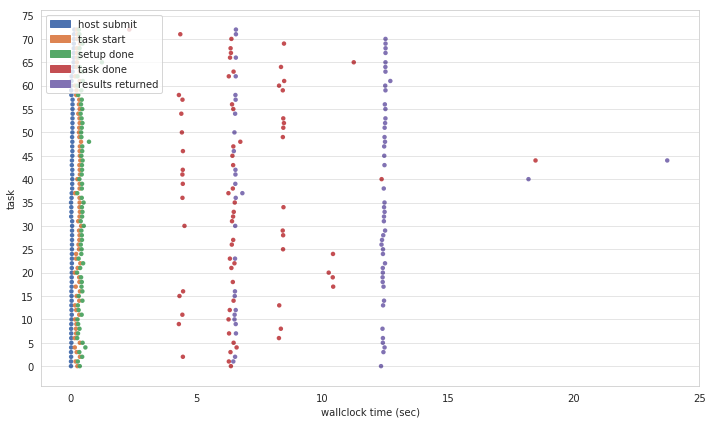

In [7]:
from training import plot_pywren_execution
plot_pywren_execution(futures)

## 2. Visits for English Pages
Recall from above that the second field of a record is the `project code` For example, the project code `en` indicates an English page. Let’s calculate the view count on English pages for each date in our dataset.

***Exercise:*** modify `is_page_english` so that it return true if a given record corresponds to an English page.

In [ ]:
from itertools import groupby
from operator import itemgetter
from functools import reduce

def aggregate_count(key_value_list):
    
    def reduce_f(obj1, obj2):
        return(obj1[0], obj1[1] + obj2[1])
    
    counts = [reduce(reduce_f, group) for _, group 
          in groupby(sorted(key_value_list), key=itemgetter(0))]
    return counts

def english_page_count(filename):
    data = read_from_s3(wikipedia_bucket, filename)
    
    # return True if a record corresponds to an english page.
    def is_page_english(page):
        if len(page.split(" ")) >= 4 and page.split(" ")[1] == "en":
            return True
        return False
    
    # filter out the english pages
    en_pages = filter(is_page_english, data.split("\n"))
    
    # projection to create (date, pagecount) pairs
    def make_date_viewcount_pair(record):
        split_record = record.split()
        
        # the daate is the first entry of the record.
        # We only want the YYYYMMDD characters.
        date = split_record[0][:8]
        
        view_count = int(split_record[3])
        return (date, view_count)
    
    en_kvpair_list = [make_date_viewcount_pair(p) for p in en_pages]

    return aggregate_count(en_kvpair_list)

print ("invoking pywren jobs...")
futures = pwex.map(english_page_count, filenames)
print ("working...")
pywren.wait(futures)


results = [f.result() for f in futures]
en_page_counts_by_date = aggregate_count([x for y in results for x in y])
print(en_page_counts_by_date)

## 3. Bonus: Finding Trends for the Time of Day.
One cool thing we can do with our data-set is to look at how popular pages trend with the time of day.

Suppose we wanted to view the pages that got the most views from 5PM-6PM each day. One "naive" solution would be to `map` a function that takes in a filename and returns a list of `(page_views, title)` pairs for each record in the given time range, and sort the aggregated results locally. This approach however, involves us iterating through some `O(million)` records on our local machine, when we ideally could do some more work in parallel.

To offload more work to the cloud, we could change our `map` function to return the 15 most popular records in each file. This would reduce the amount of work we do on our single node.

***Exercise*** Fix `fifteen_largest` and `process_file` so that it behaves as intended. Try running queries on different times of day, and note any interesting findings.

In [ ]:
import pywren
pwex = pywren.default_executor()

from heapq import heappush, heappop

# Takes a list of (page_view, page_title) pairs
# and returns the 15 pages with the largest page_view.
def fifteen_largest(list_of_pairs):
    # Hint. You can use a min heap.
    # https://docs.python.org/2/library/heapq.html
    h = []
    for kv in list_of_pairs:
        if len(kv) == 0:
            continue
        if len(h) < 15:
            heappush(h, kv)
        elif kv[0] > h[0][0]:
            heappop(h)
            heappush(h, kv)
    return h

def process_file(filename):
    data = read_from_s3(wikipedia_bucket, filename)
    data = data.split("\n")
    # Filter out pages that are not in English, or are 
    # administrative/error pages.
    def page_filter(record):
        arr = record.split(" ")
        # filter out any empty lines.
        if len(arr) < 5:
            return False
        if arr[1] == "en":
            # Filter out any error or special pages.
            if "404_error" not in arr[2] and "Main" not in arr[2] and "Special:" not in arr[2]:
                # Only approve records starting at 17:00:00                        
                if arr[0][-6:] == "170000":
                    return True
        return False

    data = filter(page_filter, data)
    
    # Given a record, return a tuple of 
    # (page_views, page_title).
    # Remember that page_view should be an int.
    def extract_kv_pair(record):
        record = record.split(" ")
        return (int(record[3]), record)
    
    data = map(extract_kv_pair, data)
    return fifteen_largest(data)

print ("invoking pywren jobs...")
futures = pwex.map(process_file, filenames)
print ("working...")
results = pywren.get_all_results(futures)

flattened_list = []
for result in results:
    for elem in result:
        flattened_list.append(elem)

for item in fifteen_largest(flattened_list):
    print(item)
